In [32]:
def Round(a,b):
    result=round(a,b)
    if result==0:
        result=round(a,(b+4))
    elif result<0.01:
        result=round(a,(b+3))
    elif result<0.1:
        result=round(a,(b+2))
    return result

def cut(cut_point,ShelfMax,ref):
    #print("cut_point",cut_point,"Shelf Max ",ShelfMax,"ref ",ref)
    if ref==True:
        point=min(cut_point,ShelfMax*1.5,ShelfMax+6)
    else:
        point=min(cut_point,ShelfMax*2,ShelfMax+12)
    return point

In [33]:
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # yellow-green
    '#17becf'   # cyan
]

In [35]:
from plotnine import *
import pandas as pd
import numpy as np
from all_func import *
from datetime import date,datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [36]:
def Calculate_Shelf_Life_Func(df = None,all_details = None):

    interaction = parallel = single = False

    #df = all_details["df"]
    df = pd.read_csv("data1_2103C.csv",index_col = 0)

    #df.columns = ["batch","time","assay"]
    df.rename(columns = {"Assay" : "assay"},inplace = True)
    
    NOB = len(np.unique(df['batch']))
    
    df['batch'] = df['batch'].astype('category')
    
    model = ols('assay ~ time * batch', data = df).fit()
    
    
    anova = sm.stats.anova_lm(model, type=2)
    
    p_value_time_batch_intercation = anova.at["time:batch","PR(>F)"]
    
    if p_value_time_batch_intercation < 0.25:
        iteraction = True
        #print("Model with interaction of batch and time is significant")
    else:
        model = ols('assay ~ time + batch', data=df).fit()
        anova = sm.stats.anova_lm(model, type=2)
        p_value_for_sig_batch = anova.at["batch","PR(>F)"]
        
        if p_value_for_sig_batch < 0.25:
            parallel = True

        else:
            single = True
                  
    if iteraction:
        result = Calculate_Shelf_Life_For_Different_Slopes_Func(df)
    elif parallel:
        result = Calculate_Shelf_Life_For_Parallel_Slopes_Func()
    elif single:
        result = Calculate_Shelf_Life_For_One_Slope_Func()
    return(result)
    

In [37]:
def Calculate_Shelf_Life_For_Different_Slopes_Func(df,
                 other_details = {"Type of Threshold" : "Both",
                                  "ulv" : 3,
                                  "llv" : 1,
                                  "refrigerator" : False}):

    NOB = len(np.unique(df['batch']))
    max_time = df['time'].max()
    model = ols('assay ~ time * batch', data=df).fit()
    anova = sm.stats.anova_lm(model, type=2)
    coefficients = model.params

    intercepts = [coefficients[0]]
    slopes = [coefficients[NOB]]
    for i in range(1,NOB):
        intercepts.append(coefficients[0] + coefficients[i])
        slopes.append(coefficients[NOB] + coefficients[NOB + i])

    A = ggplot() + geom_point(data = df, mapping = aes(x = 'time',y = 'assay', colour ='batch'))#,shape='batch'))
    A = A + scale_color_manual(values = colors[0:NOB])
    for i in range(NOB):
        A = A + geom_abline(slope = slopes[i],intercept = intercepts[i], colour = colors[i],size = 0.5)
    #print(A)
    if other_details["Type of Threshold"] == "Upper specific value":
        all_upper_cut = []
        for i in range(NOB):
            s = len(np.arange(0, max_time + 15, 0.01 ))
            Q = {'batch': np.repeat(i + 1, repeats = s),'time': np.arange(0, max_time + 15, 0.01)}
            newdata = pd.DataFrame(data = Q)
            predictions = model.get_prediction(newdata).summary_frame(alpha = 0.05)
            pred_CI = pd.concat([newdata,predictions],axis = 1)
            
            A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_upper'),color = colors[i],linetype = "dashed",size = 0.3)
            
            upper_cut = cutU(pred_CI['mean_ci_upper'], other_details["ulv"], pred_CI['time'], max_time, slopes[i],other_details["refrigerator"])
            all_upper_cut.append(upper_cut)
            
        A = A + geom_hline(yintercept = (other_details["ulv"]), linetype = 'dashed', size = 0.4)
        
        Cut = Round(min(all_upper_cut),2)
        print(Cut,max_time,other_details["refrigerator"])
        shelf_Cut = Round(cut(Cut,max_time,other_details["refrigerator"]),2)   
        
    elif other_details["Type of Threshold"] == "Lower specific value":
        all_lower_cut = []
        for i in range(NOB):
            s = len(np.arange(0, max_time + 15, 0.01 ))
            Q = {'batch': np.repeat(i + 1, repeats = s),'time': np.arange(0, max_time + 15, 0.01)}
            newdata = pd.DataFrame(data = Q)
            predictions = model.get_prediction(newdata).summary_frame(alpha = 0.05)
            pred_CI = pd.concat([newdata,predictions],axis = 1)
            A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_lower'),color = colors[i],linetype = "dashed",size = 0.3)
        
            lower_cut = cutU(pred_CI['mean_ci_lower'], other_details["llv"], pred_CI['time'], max_time, slopes[i],other_details["refrigerator"])
            all_lower_cut.append(lower_cut)
            
        A = A + geom_hline(yintercept = (other_details["llv"]), linetype = 'dashed', size = 0.4)

        Cut = Round(min(all_lower_cut),2)
        print(Cut,max_time,other_details["refrigerator"])
        shelf_Cut = Round(cut(Cut,max_time,other_details["refrigerator"]),2)  
    else:
        all_upper_cut = []
        all_lower_cut = []
        for i in range(NOB):
            s = len(np.arange(0, max_time + 15, 0.01 ))
            Q = {'batch': np.repeat(i + 1, repeats = s),'time': np.arange(0, max_time + 15, 0.01)}
            newdata = pd.DataFrame(data = Q)
            predictions = model.get_prediction(newdata).summary_frame(alpha = 0.05)
            pred_CI = pd.concat([newdata,predictions],axis = 1)
            A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_upper'),color = colors[i],linetype = "dashed",size = 0.3)
            A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_lower'),color = colors[i],linetype = "dashed",size = 0.3)

            upper_cut = cutU(pred_CI['mean_ci_upper'], other_details["ulv"], pred_CI['time'], max_time, slopes[i],other_details["refrigerator"])
            lower_cut = cutL(pred_CI['mean_ci_lower'], other_details["ulv"], pred_CI['time'], max_time, slopes[i],other_details["refrigerator"])

            all_upper_cut.append(upper_cut)
            all_lower_cut.append(lower_cut)

        all_cuts = all_upper_cut + all_lower_cut
            
        Cut = Round(min(all_cuts),2)
        
        shelf_Cut = Round(cut(Cut,max_time,other_details["refrigerator"]),2)
        
        A = A + geom_hline(yintercept = (other_details["llv"]), linetype = 'dashed', size = 0.4)
        A = A + geom_hline(yintercept = (other_details["ulv"]), linetype = 'dashed', size = 0.4)
    
    if other_details["refrigerator"] ==True:
        if (shelf_Cut==Cut and shelf_Cut<max_time+6 and shelf_Cut>0):
            A = A + geom_vline(xintercept = shelf_Cut,color = "black", linetype='dashed', size=0.4)
    else:
        if (shelf_Cut==Cut and shelf_Cut<max_time+12 and shelf_Cut>0):
            A = A + geom_vline(xintercept = shelf_Cut,color = "black", linetype='dashed', size=0.4)
    return({
        "plot" : A,
        "anova1" : anova
    })


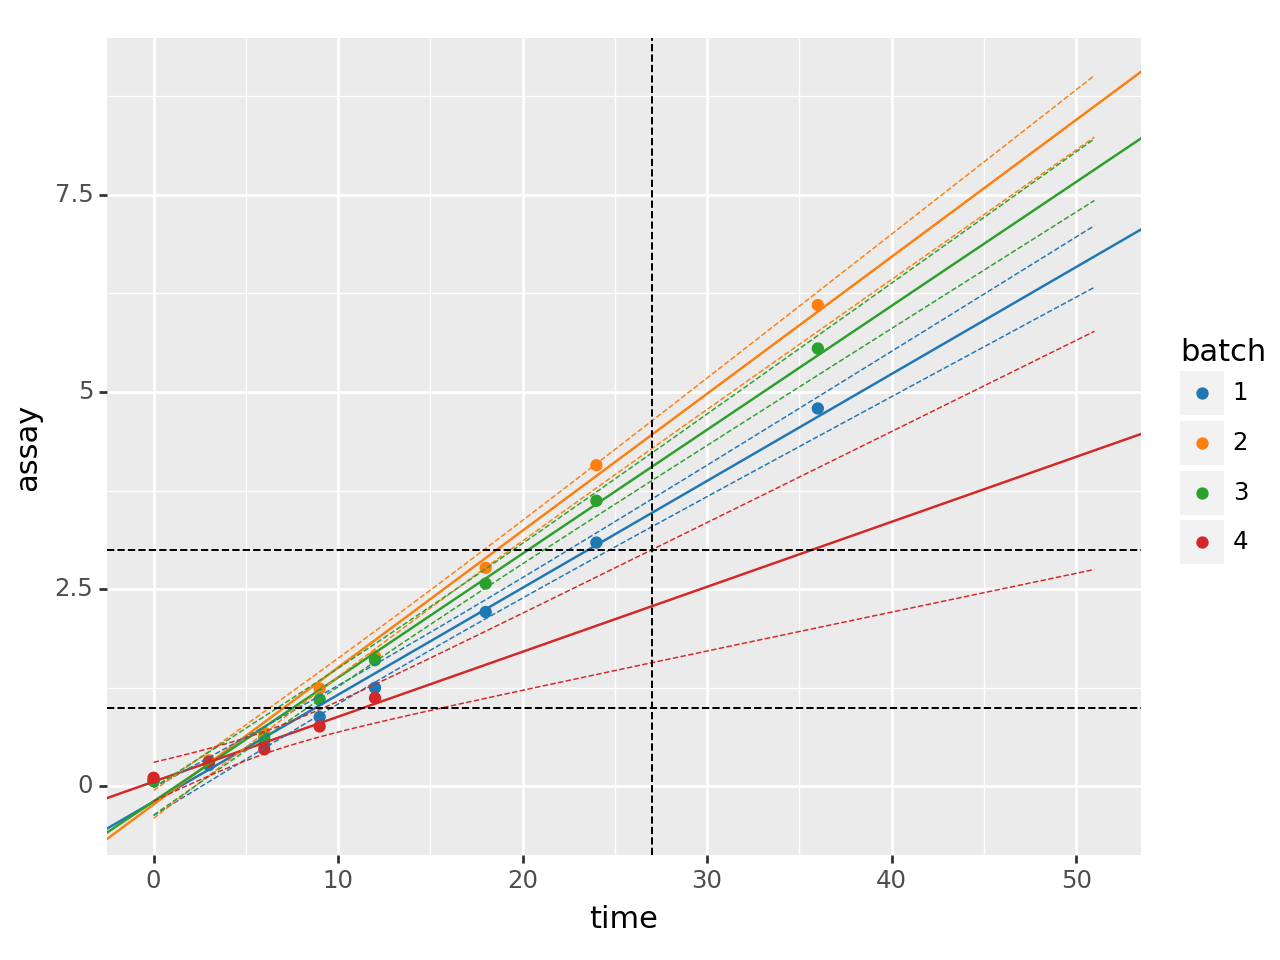

<Figure Size: (640 x 480)>

In [38]:
df = pd.read_csv("data1_2103C.csv",index_col = 0)
df['batch'] = df['batch'].astype('category')
df.rename(columns = {"Assay" : "assay"},inplace = True)
Z = Calculate_Shelf_Life_For_Different_Slopes_Func(df)
Z["plot"]

# Parallel Lines

In [39]:
df = pd.read_csv("parallel.csv")
df['batch'] = df['batch'].astype('category')
df.rename(columns = {"Assay" : "assay"},inplace = True)

In [47]:
def Calculate_Shelf_Life_For_Parallel_Slopes_Func(df,
                 other_details = {"Type of Threshold" : "Upper specific value",
                                  "ulv" : 102,
                                  "llv" : 99,
                                  "refrigerator" : False}):
    NOB = len(np.unique(df['batch']))
    max_time = df['time'].max()
    model = ols('assay ~ time + batch', data=df).fit()
    anova = sm.stats.anova_lm(model, type=2)


    coefficients = model.params
    intercepts = [coefficients[0]]
    slopes = coefficients[NOB]
    for i in range(1,NOB):
        intercepts.append(coefficients[0] + coefficients[i])

    A = ggplot() + geom_point(data = df, mapping = aes(x = 'time',y = 'assay', colour ='batch'))#,shape='batch'))
    A = A + scale_color_manual(values = colors[0:NOB])
    for i in range(NOB):
        A = A + geom_abline(slope = slopes,intercept = intercepts[i], colour = colors[i],size = 0.5)
    #print(A)
    if other_details["Type of Threshold"] == "Upper specific value":
        all_upper_cut = []
        for i in range(NOB):
            s = len(np.arange(0, max_time + 15, 0.01 ))
            Q = {'batch': np.repeat(i + 1, repeats = s),'time': np.arange(0, max_time + 15, 0.01)}
            newdata = pd.DataFrame(data = Q)
            predictions = model.get_prediction(newdata).summary_frame(alpha = 0.05)
            pred_CI = pd.concat([newdata,predictions],axis = 1)
            
            A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_upper'),color = colors[i],linetype = "dashed",size = 0.3)
            A = A + geom_ribbon(data = pred_CI,mapping = aes(x = 'time',ymin = 'mean',ymax = 'mean_ci_upper'),
                           fill = colors[i],alpha = 0.15)
            
            upper_cut = cutU(pred_CI['mean_ci_upper'], other_details["ulv"], pred_CI['time'], max_time, slopes,other_details["refrigerator"])
            all_upper_cut.append(upper_cut)
            
        A = A + geom_hline(yintercept = (other_details["ulv"]), linetype = 'dashed', size = 0.4)
        
        Cut = Round(min(all_upper_cut),2)
        #print(Cut,max_time,other_details["refrigerator"])
        shelf_Cut = Round(cut(Cut,max_time,other_details["refrigerator"]),2)   
        
    elif other_details["Type of Threshold"] == "Lower specific value":
        all_lower_cut = []
        for i in range(NOB):
            s = len(np.arange(0, max_time + 15, 0.01 ))
            Q = {'batch': np.repeat(i + 1, repeats = s),'time': np.arange(0, max_time + 15, 0.01)}
            newdata = pd.DataFrame(data = Q)
            predictions = model.get_prediction(newdata).summary_frame(alpha = 0.05)
            pred_CI = pd.concat([newdata,predictions],axis = 1)
            A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_lower'),color = colors[i],linetype = "dashed",size = 0.3)
            A = A + geom_ribbon(data = pred_CI,mapping = aes(x = 'time',ymin = 'mean',ymax = 'mean_ci_lower'),
                           fill = colors[i],alpha = 0.2)
        
            lower_cut = cutU(pred_CI['mean_ci_lower'], other_details["llv"], pred_CI['time'], max_time, slopes,other_details["refrigerator"])
            all_lower_cut.append(lower_cut)
            
        A = A + geom_hline(yintercept = (other_details["llv"]), linetype = 'dashed', size = 0.4)
    
        Cut = Round(min(all_lower_cut),2)
        #print(Cut,max_time,other_details["refrigerator"])
        shelf_Cut = Round(cut(Cut,max_time,other_details["refrigerator"]),2)  
    else:
        all_upper_cut = []
        all_lower_cut = []
        for i in range(NOB):
            s = len(np.arange(0, max_time + 15, 0.01 ))
            Q = {'batch': np.repeat(i + 1, repeats = s),'time': np.arange(0, max_time + 15, 0.01)}
            newdata = pd.DataFrame(data = Q)
            predictions = model.get_prediction(newdata).summary_frame(alpha = 0.05)
            pred_CI = pd.concat([newdata,predictions],axis = 1)
            A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_upper'),color = colors[i],linetype = "dashed",size = 0.3)
            A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_lower'),color = colors[i],linetype = "dashed",size = 0.3)
    
            A = A + geom_ribbon(data = pred_CI,mapping = aes(x = 'time',ymin = 'mean_ci_lower',ymax = 'mean_ci_upper'),
                           fill = colors[i],alpha = 0.1)
    
            upper_cut = cutU(pred_CI['mean_ci_upper'], other_details["ulv"], pred_CI['time'], max_time, slopes,other_details["refrigerator"])
            lower_cut = cutL(pred_CI['mean_ci_lower'], other_details["ulv"], pred_CI['time'], max_time, slopes,other_details["refrigerator"])
    
        all_upper_cut.append(upper_cut)
        all_lower_cut.append(lower_cut)
    
        all_cuts = all_upper_cut + all_lower_cut
            
        Cut = Round(min(all_cuts),2)
        
        shelf_Cut = Round(cut(Cut,max_time,other_details["refrigerator"]),2)
        
        A = A + geom_hline(yintercept = (other_details["llv"]), linetype = 'dashed', size = 0.4)
        A = A + geom_hline(yintercept = (other_details["ulv"]), linetype = 'dashed', size = 0.4)
    
    if other_details["refrigerator"] ==True:
        if (shelf_Cut==Cut and shelf_Cut<max_time+6 and shelf_Cut>0):
            A = A + geom_vline(xintercept = shelf_Cut,color = "black", linetype='dashed', size=0.4)
    else:
        if (shelf_Cut==Cut and shelf_Cut<max_time+12 and shelf_Cut>0):
            A = A + geom_vline(xintercept = shelf_Cut,color = "black", linetype='dashed', size=0.4)
    #print(A)
    return({
        "model_type" : "C",
        "plot" : A,
        "model" : model,
        "shelf_life" : shelf_Cut
        "anova1" : anova
    })

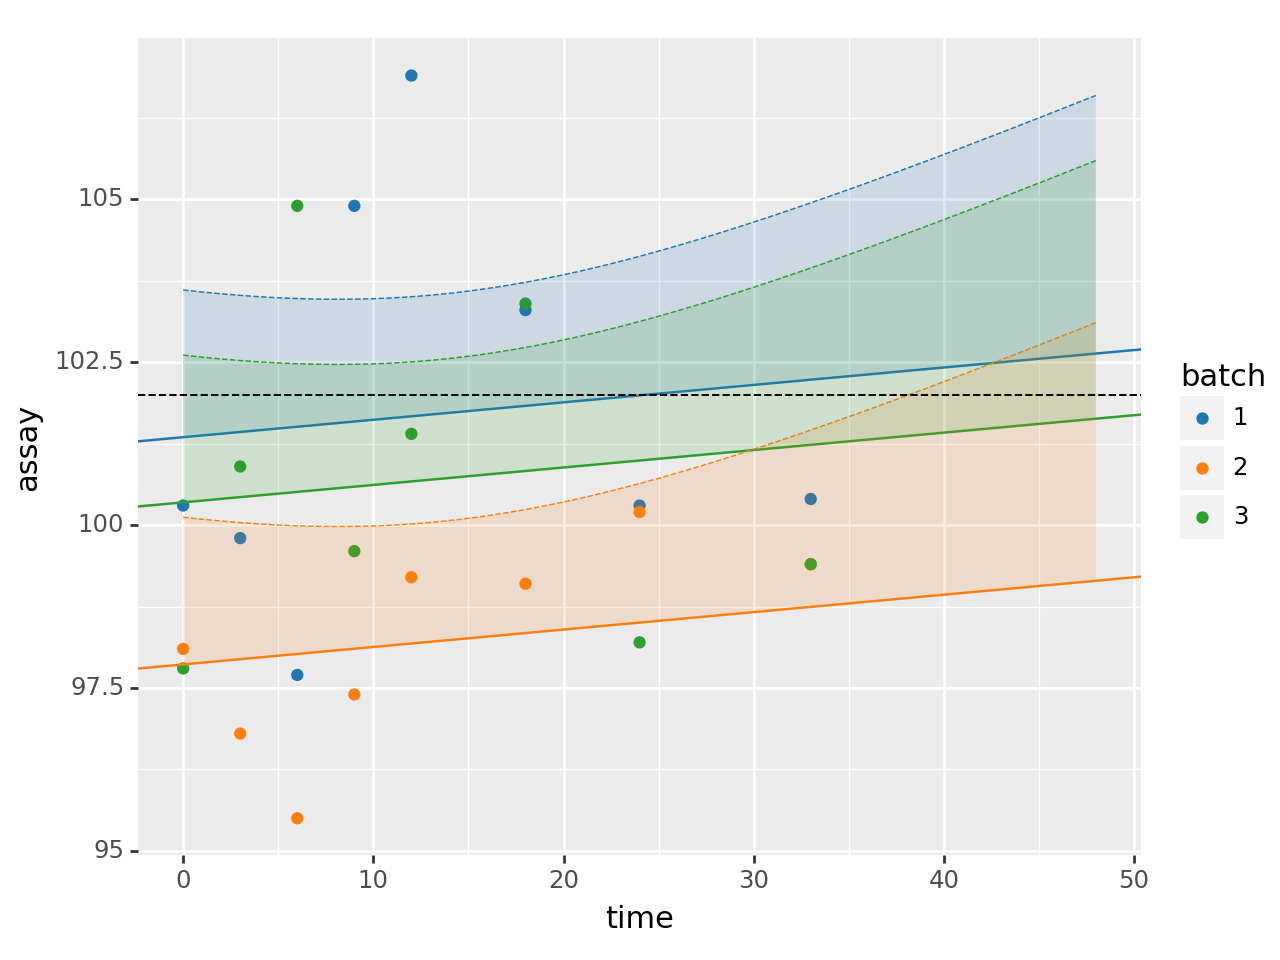

{'plot': <Figure Size: (640 x 480)>,
 'anova1':             df      sum_sq    mean_sq         F    PR(>F)
 batch      2.0   51.600833  25.800417  4.183695  0.030346
 time       1.0    1.890818   1.890818  0.306608  0.585907
 Residual  20.0  123.337932   6.166897       NaN       NaN}

In [48]:
Calculate_Shelf_Life_For_Parallel_Slopes_Func(df)

# Single Line

In [3]:
import pandas as pd
df = pd.read_csv("single_line.csv")
df

batch  time  Assay1
0       1     0   0.010
1       1     3   0.008
2       1     6   0.010
3       1     9   0.003
4       1    12   0.013
5       1    18   0.017
6       1    24   0.018
7       1    33   0.020
8       2     0   0.010
9       2     3   0.009
10      2     6   0.012
11      2     9   0.003
12      2    12   0.014
13      2    18   0.020
14      2    24   0.020
15      2    33   0.020
16      3     0   0.008
17      3     3   0.008
18      3     6   0.011
19      3     9   0.001
20      3    12   0.014
21      3    18   0.020
22      3    24   0.019
23      3    33   0.020

In [98]:
def Calculate_Shelf_Life_For_One_Slope_Func(df,
                                           other_details = {"Type of Threshold" : "LLower specific value",
                                  "ulv" : 0.05,
                                  "llv" : 0.01,
                                  "refrigerator" : False}):

    df['batch'] = df['batch'].astype('category')
    df.rename(columns = {"Assay1" : "assay"},inplace = True)
    NOB = len(np.unique(df['batch']))
    max_time = df['time'].max()
    model = ols('assay ~ time', data=df).fit()
    anova = sm.stats.anova_lm(model, type=2)

    coefficients = model.params
    intercepts = coefficients[0]
    slopes = coefficients[1]

    A = ggplot() + geom_point(data = df, mapping = aes(x = 'time',y = 'assay', colour ='batch'))#,shape='batch'))

    A = A + scale_color_manual(values = colors[0:NOB])
    A = A + geom_abline(slope = slopes,intercept = intercepts, colour = "black",size = 0.5)

    if other_details["Type of Threshold"] == "Upper specific value":
        upper_cut = []
        s = len(np.arange(0, max_time + 15, 0.01 ))
        Q = {'time': np.arange(0, max_time + 15, 0.01)}
        newdata = pd.DataFrame(data = Q)
        predictions = model.get_prediction(newdata).summary_frame(alpha = 0.05)
        pred_CI = pd.concat([newdata,predictions],axis = 1)
        
        A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_upper'),color = "grey",linetype = "dashed",size = 0.3)
        A = A + geom_ribbon(data = pred_CI,mapping = aes(x = 'time',ymin = 'mean',ymax = 'mean_ci_upper'),
                       fill = "grey",alpha = 0.15)
        
        upper_cut = cutU(pred_CI['mean_ci_upper'], other_details["ulv"], pred_CI['time'], max_time, slopes,other_details["refrigerator"])
        
        Cut = upper_cut
        A = A + geom_hline(yintercept = (other_details["ulv"]), linetype = 'dashed', size = 0.4)
    
        shelf_Cut = Round(cut(upper_cut,max_time,other_details["refrigerator"]),2)   
    
    elif other_details["Type of Threshold"] == "Lower specific value":
        lower_cut = []
        s = len(np.arange(0, max_time + 15, 0.01 ))
        Q = {'time': np.arange(0, max_time + 15, 0.01)}
        newdata = pd.DataFrame(data = Q)
        predictions = model.get_prediction(newdata).summary_frame(alpha = 0.05)
        pred_CI = pd.concat([newdata,predictions],axis = 1)
        A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_lower'),color = "grey",linetype = "dashed",size = 0.3)
        A = A + geom_ribbon(data = pred_CI,mapping = aes(x = 'time',ymin = 'mean',ymax = 'mean_ci_lower'),
                       fill = "grey",alpha = 0.2)
    
        lower_cut = cutU(pred_CI['mean_ci_lower'], other_details["llv"], pred_CI['time'], max_time, slopes,other_details["refrigerator"])
            
        A = A + geom_hline(yintercept = (other_details["llv"]), linetype = 'dashed', size = 0.4)
    
        #Cut = Round(min(all_lower_cut),2)
        #print(Cut,max_time,other_details["refrigerator"])
        shelf_Cut = Round(cut(lower_cut,max_time,other_details["refrigerator"]),2)  
    else:
        s = len(np.arange(0, max_time + 15, 0.01 ))
        Q = {'time': np.arange(0, max_time + 15, 0.01)}
        newdata = pd.DataFrame(data = Q)
        predictions = model.get_prediction(newdata).summary_frame(alpha = 0.05)
        pred_CI = pd.concat([newdata,predictions],axis = 1)
        A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_upper'),color = "grey",linetype = "dashed",size = 0.3)
        A = A + geom_line(data = pred_CI,mapping = aes(x = 'time',y = 'mean_ci_lower'),color = "grey",linetype = "dashed",size = 0.3)
    
        A = A + geom_ribbon(data = pred_CI,mapping = aes(x = 'time',ymin = 'mean_ci_lower',ymax = 'mean_ci_upper'),
                       fill = "grey",alpha = 0.1)
    
        upper_cut = cutU(pred_CI['mean_ci_upper'], other_details["ulv"], pred_CI['time'], max_time, slopes,other_details["refrigerator"])
        lower_cut = cutL(pred_CI['mean_ci_lower'], other_details["ulv"], pred_CI['time'], max_time, slopes,other_details["refrigerator"])
    
        #all_upper_cut.append(upper_cut)
        #all_lower_cut.append(lower_cut)
    
        all_cuts = [lower_cut,upper_cut] 
            
        Cut = Round(min(all_cuts),2)
        
        A = A + geom_hline(yintercept = (other_details["llv"]), linetype = 'dashed', size = 0.4)
        A = A + geom_hline(yintercept = (other_details["ulv"]), linetype = 'dashed', size = 0.4)

        shelf_Cut = Round(cut(Cut,max_time,other_details["refrigerator"]),2)

    if other_details["refrigerator"] ==True:
        if (shelf_Cut==Cut and shelf_Cut<max_time+6 and shelf_Cut>0):
            A = A + geom_vline(xintercept = shelf_Cut,color = "black", linetype='dashed', size=0.4)
    else:
        if (shelf_Cut==Cut and shelf_Cut<max_time+12 and shelf_Cut>0):
            A = A + geom_vline(xintercept = shelf_Cut,color = "black", linetype='dashed', size=0.4)

    print(A)
    

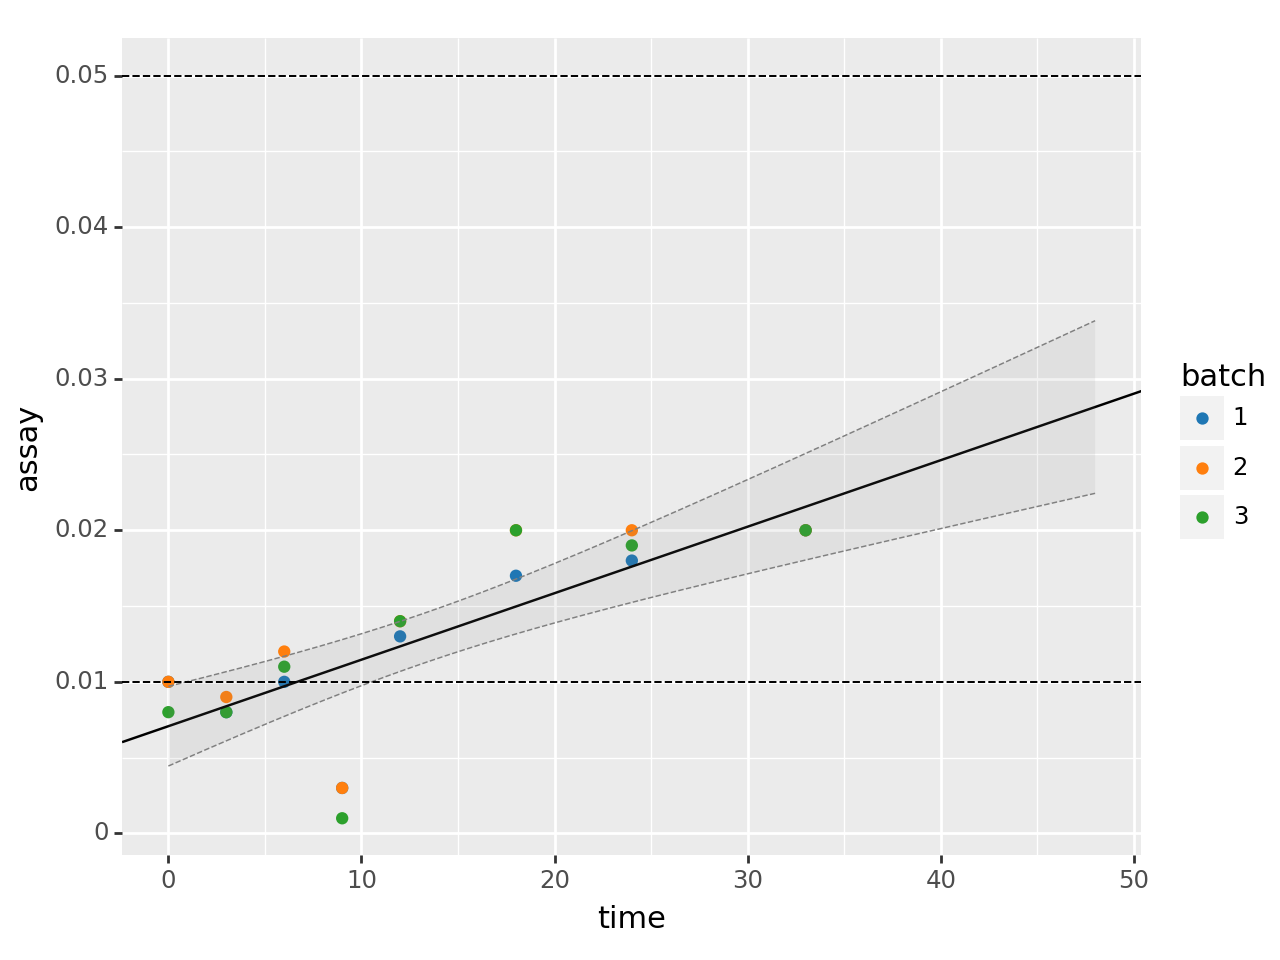

In [99]:
Calculate_Shelf_Life_For_One_Slope_Func(df)